In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
LOCATION_CNT = 39
BOROUGH_CNT = 25
WEEKLY_BATCH = 7

TEST_SIZE = 15
TRAIN_SIZE = 240
BATCH_SIZE = 40

TRAIN_ITER = 200
BATCH_ITER = TRAIN_SIZE // BATCH_SIZE

In [3]:
csv_name = 'MonthlyAverageAirPollutionInSeoul.csv'

seoul_map = [ # 9 by 8 matrix, 25 borough
    [0, 0, 0, 0, '도봉구', '노원구', 0, 0],
    [0, 0, 0, '강북구', '강북구', '노원구', '노원구', 0],
    [0, '은평구', '종로구', '성북구', '성북구', '성북구', '중랑구', 0],
    [0, '은평구', '서대문구', '종로구', '종로구', '동대문구', '중랑구', 0],
    [0, '은평구', '서대문구', '서대문구', '중구', '성동구', '광진구', '강동구'],
    [0, '마포구', '마포구', '마포구', '용산구', '강남구', '송파구', '강동구'],
    ['강서구', '강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', 0],
    [0, '양천구', '영등포구', '관악구', '서초구', '강남구', '송파구', 0],
    [0, '구로구', '금천구', '관악구', '서초구', 0, 0, 0]
]

In [4]:
def read_csv(name):
    with open(name) as f:
        raw_data = f.read().strip()

    del_quote = raw_data.replace("\"", '')
    data = list(map(lambda x: x.split(','), del_quote.split('\n')))[1:] # csv header

    splitted = []

    ptr = 0
    for i in range(len(data) // LOCATION_CNT):
        splitted.append(data[ptr:ptr+LOCATION_CNT])
        ptr += LOCATION_CNT
    
    ## test case
    for date_list in splitted:
        date = date_list[0][0] # index 0:date
        for local in date_list:
            if date != local[0]:
                raise ValueError(date + ' is not same as ' + 'local[0]')
    
    def filter_borough(dic):
        return dict(filter(lambda t: '구' in t[0], dic.items())) # filter not road name only borough 

    # index 0:date, 1:local name, 6:pms
    pms = dict(map(lambda x: (x[0][0], dict(map(lambda t: (t[1], t[6]), x))), splitted))
    pms_filtered = dict(filter(lambda x: '' not in x[1].values(), pms.items())) # csv data contains spaces
    pms_filtered2 = dict(map(lambda x: (x[0], filter_borough(x[1])), pms_filtered.items()))
    
    return pms_filtered2

In [5]:
def geographical_mapping(pms_data):
    def dict2seoul(p):
        return list(map(lambda t: list(map(lambda x: int(p[x]) if x != 0 else 0, t)), seoul_map))

    # map dict to seoul geographic map
    pms_mapped = dict(map(lambda p: (p[0], dict2seoul(p[1])), pms_data.items())) 
    return pms_mapped

In [6]:
def generate_dataset(data):
    pms_mapped = geographical_mapping(data)
    pms_data = list(map(lambda x: x[1], sorted(pms_mapped.items()))) 

    # tie data to WEEKLY_BATCH(7) batches
    pms_sampled = list(map(lambda i: pms_data[i:i+WEEKLY_BATCH], range(len(pms_data) - WEEKLY_BATCH - 1)))
    pms_result = list(map(lambda x: list(map(lambda t: t[1], sorted(x[1].items()))), sorted(data.items())))
    pms_result = pms_result[WEEKLY_BATCH+1:]
    
    return pms_sampled, pms_result

In [7]:
pms_data = read_csv(csv_name)
pms_sampled, pms_result = generate_dataset(pms_data)

In [8]:
test_sampled = pms_sampled[-TEST_SIZE:]
test_result = pms_result[-TEST_SIZE:]

data_set = list(zip(pms_sampled[:-TEST_SIZE], pms_result[:-TEST_SIZE]))
np.random.shuffle(data_set)

train_set, cv_set = data_set[:TRAIN_SIZE], data_set[TRAIN_SIZE:]

train_sampled = list(map(lambda x: x[0], train_set))
train_result = list(map(lambda x: x[1], train_set))

cv_sampled = list(map(lambda x: x[0], cv_set))
cv_result = list(map(lambda x: x[1], cv_set))

In [9]:
X = tf.placeholder(tf.float32, [None, WEEKLY_BATCH, 9, 8]) # metrix size [9, 8]
Y = tf.placeholder(tf.float32, [None, BOROUGH_CNT])

Xt = tf.transpose(X, [1, 0, 2, 3])

In [10]:
reused = False

def layer2conv(layer):
    global reused
    
    with tf.variable_scope('conv_layer', reuse=reused):
        w1 = tf.get_variable('w1', shape=[3, 3, 1, 4],
                            initializer=tf.random_normal_initializer(stddev=0.02))
        w2 = tf.get_variable('w2', shape=[3, 3, 4, 8],
                            initializer=tf.random_normal_initializer(stddev=0.02))
        w3 = tf.get_variable('w3', shape=[3, 3, 8, 16],
                            initializer=tf.random_normal_initializer(stddev=0.02))
        
        layerT = tf.reshape(layer, [-1, 9, 8, 1])
        
        l1 = tf.nn.conv2d(layerT, w1, strides=[1, 1, 1, 1], padding='SAME')
        l1 = tf.nn.relu(tf.contrib.layers.batch_norm(l1))
        
        l2 = tf.nn.conv2d(l1, w2, strides=[1, 1, 1, 1], padding='SAME')
        l2 = tf.nn.relu(tf.contrib.layers.batch_norm(l2))
        
        l3 = tf.nn.conv2d(l2, w3, strides=[1, 1, 1, 1], padding='SAME')
        l3 = tf.nn.relu(tf.contrib.layers.batch_norm(l3))
        
        l3_reshaped = tf.reshape(l3, [-1, 9 * 8 * 16]) # flatten conv layer
    
    reused = True
    return l3_reshaped

conv = [layer2conv(Xt[i]) for i in range(WEEKLY_BATCH)]
convT = tf.transpose(conv, [1, 0, 2])

In [11]:
gru_cell = tf.contrib.rnn.LSTMCell(8)
out, state = tf.nn.dynamic_rnn(gru_cell, convT, dtype=tf.float32)

l4 = tf.transpose(out, [1, 0, 2])[-1]

In [12]:
w4 = tf.get_variable('w4', shape=[8, BOROUGH_CNT],
                    initializer=tf.random_normal_initializer(stddev=0.02))

l5 = tf.contrib.layers.batch_norm(tf.matmul(l4, w4))
pred = tf.nn.relu(l5)

loss = tf.reduce_mean(tf.square(Y - pred))
opt = tf.train.AdamOptimizer(0.1).minimize(loss)

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [14]:
train_loss = []
cv_loss = []

for i in range(TRAIN_ITER + 1):
    ptr = 0
    for _ in range(BATCH_ITER):
        _, trainloss = sess.run([opt, loss], feed_dict={X: train_sampled[ptr:ptr+BATCH_SIZE], 
                                                       Y: train_result[ptr:ptr+BATCH_SIZE]})
        
        cvloss = sess.run(loss, feed_dict={X: cv_sampled, Y: cv_result})
        
        ptr += BATCH_SIZE

    train_loss.append(trainloss)
    cv_loss.append(cvloss)
    
    if i % (TRAIN_ITER // 10) == 0:
        print(i/TRAIN_ITER, cvloss)

0.0 2652.21
0.1 1679.83
0.2 1073.74
0.3 719.528
0.4 533.242
0.5 441.817
0.6 402.002
0.7 385.754
0.8 379.45
0.9 377.035
1.0 376.087


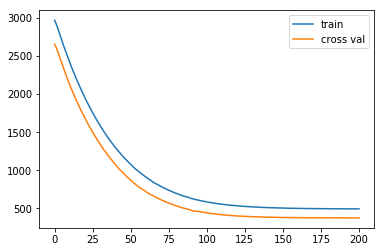

In [15]:
plt.plot(train_loss, label='train')
plt.plot(cv_loss, label='cross val')
plt.legend()

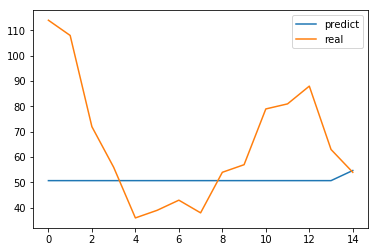

In [16]:
predict = sess.run(pred, feed_dict={X: test_sampled})
pred_gangnam = list(map(lambda x: x[0], predict))
real_gangnam = list(map(lambda x: x[0], test_result))

plt.plot(pred_gangnam, label='predict')
plt.plot(real_gangnam, label='real')
plt.legend()

In [17]:
sess.close()